### グラフ交差実験・描画ツール【gdrawer】(全探索 ver.)

---

##### このツールでできること

- General position におけるランダム $k$-近接グラフ の描写(辺数,頂点数,交差数：指定可能)
- 任意の頂点描画場所における $k$-近接グラフ描写
- 様々な実験回数における交差数の計算実験
- 全探索における純粋な厚みの計算
- 辺交差グラフの作成(彩色数の描写)


In [1]:
import random
import itertools
import math
import networkx as nx  # noqa: F401
import matplotlib.pyplot as plt
import pandas as pd
from fastprogress.fastprogress import progress_bar  # 進捗を確認するツールです
from matplotlib.patches import Patch
import tkinter.font as tkFont
import tkinter.messagebox as messagebox
import csv
import os
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

from tkinter import simpledialog
from matplotlib.patches import Circle
from shapely.geometry import Point
import numpy as np
from shapely.geometry import Polygon


In [2]:
# Mygraph_style_base
node_color = "gray"
node_size = 600
edge_color = "black"
font_size = 15
font_color = "white"
width = 2


#### General position の確認コード ↓

---

1. 任意の 3 点が同一直線上にない
2. 任意の 4 点が同一円周上にない


In [3]:
def is_collinear(
    x1, y1, x2, y2, x3, y3
):  # 3点が同一線上にないかの確認(General position判定で使用)
    return (y2 - y1) * (x3 - x2) == (y3 - y2) * (x2 - x1)


def is_cocircular(
    x1, y1, x2, y2, x3, y3, x4, y4
):  # 4点が同一円上にないかの確認(General position判定で使用)
    d = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    if d == 0:
        return True, None, None, None
    else:
        cen_x = (
            (x1**2 + y1**2) * (y2 - y3)
            + (x2**2 + y2**2) * (y3 - y1)
            + (x3**2 + y3**2) * (y1 - y2)
        ) / d
        cen_y = (
            (x1**2 + y1**2) * (x3 - x2)
            + (x2**2 + y2**2) * (x1 - x3)
            + (x3**2 + y3**2) * (x2 - x1)
        ) / d
        r = math.sqrt((cen_x - x1) ** 2 + (cen_y - y1) ** 2)
        is_on_circle = math.isclose(
            (x4 - cen_x) ** 2 + (y4 - cen_y) ** 2, r**2, rel_tol=1e-9
        )
        return is_on_circle, cen_x, cen_y, r


def generate_points(n):  # General position判定
    Gen_xy = {}
    while len(Gen_xy) < n:
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        if (x, y) not in Gen_xy.values():
            flag = True
            if len(Gen_xy) >= 2:
                for i, j in itertools.combinations(Gen_xy.keys(), 2):
                    if is_collinear(
                        Gen_xy[i][0], Gen_xy[i][1], Gen_xy[j][0], Gen_xy[j][1], x, y
                    ):
                        flag = False
                        break
            if flag and len(Gen_xy) >= 3:
                for i, j, k in itertools.combinations(Gen_xy.keys(), 3):
                    if is_cocircular(
                        Gen_xy[i][0],
                        Gen_xy[i][1],
                        Gen_xy[j][0],
                        Gen_xy[j][1],
                        Gen_xy[k][0],
                        Gen_xy[k][1],
                        x,
                        y,
                    )[0]:
                        flag = False
                        break
            if flag:
                Gen_xy[len(Gen_xy)] = (x, y)
    return Gen_xy


def point3_circle(
    x1, y1, x2, y2, x3, y3
):  # 3つの頂点から中心と半径を取り出す関数(k-DGで使用)
    d = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    cen_x = (
        (x1**2 + y1**2) * (y2 - y3)
        + (x2**2 + y2**2) * (y3 - y1)
        + (x3**2 + y3**2) * (y1 - y2)
    ) / d
    cen_y = (
        (x1**2 + y1**2) * (x3 - x2)
        + (x2**2 + y2**2) * (x1 - x3)
        + (x3**2 + y3**2) * (x2 - x1)
    ) / d
    # 半径の計算
    r = math.sqrt((cen_x - x1) ** 2 + (cen_y - y1) ** 2)
    return (cen_x, cen_y, r)


def point2_diameter_circle(
    x1, y1, x2, y2
):  # 2つの頂点を結ぶ直径から中心と半径を取り出す関数(k-GGで使用)
    cen_x = (x1 + x2) / 2
    cen_y = (y1 + y2) / 2
    # 半径の計算
    r = math.sqrt((cen_x - x1) ** 2 + (cen_y - y1) ** 2)
    return (cen_x, cen_y, r)


def point2_radius_circle(
    x1, y1, x2, y2
):  # 2つの頂点を結ぶ半径から2円を取り出す関数(k-RNGで使用)
    r = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return (x1, y1, x2, y2, r)


##### 各近接グラフの生成関数

- k-DG
- k-GG
- k-RNG
- k-NNG
- (k,l)-MTG
- 辺交差グラフ


In [4]:
# k-DG(N)を生成する関数
def kDG_generate(Gen_xy, k_num):
    in_count = 0
    graph_edges = set()
    for i, j, k in itertools.combinations(Gen_xy.keys(), 3):
        in_count = 0
        flag = True
        result = point3_circle(
            Gen_xy[i][0],
            Gen_xy[i][1],
            Gen_xy[j][0],
            Gen_xy[j][1],
            Gen_xy[k][0],
            Gen_xy[k][1],
        )
        cen_x, cen_y, r = result[0], result[1], result[2]
        for l in Gen_xy.keys():  # noqa: E741
            if (l != i) and (l != j) and (l != k):
                if (Gen_xy[l][0] - cen_x) ** 2 + (Gen_xy[l][1] - cen_y) ** 2 < r**2:
                    in_count += 1
                    if in_count > k_num:
                        flag = False
                        break
        if flag:
            graph_edges.add(tuple(sorted((i, j))))
            graph_edges.add(tuple(sorted((j, k))))
            graph_edges.add(tuple(sorted((k, i))))
    return graph_edges


# k-GG(N)を生成する関数
def kGG_generate(Gen_xy, k_num):
    in_count = 0
    graph_edges = set()
    for i, j in itertools.combinations(Gen_xy.keys(), 2):
        in_count = 0
        flag = True
        result = point2_diameter_circle(
            Gen_xy[i][0], Gen_xy[i][1], Gen_xy[j][0], Gen_xy[j][1]
        )
        cen_x, cen_y, r = result[0], result[1], result[2]
        for l in Gen_xy.keys():  # noqa: E741
            if (l != i) and (l != j):
                if (Gen_xy[l][0] - cen_x) ** 2 + (Gen_xy[l][1] - cen_y) ** 2 < r**2:
                    in_count += 1
                    if in_count > k_num:
                        flag = False
                        break
        if flag:
            graph_edges.add(tuple(sorted((i, j))))
    return graph_edges


# k-RNG(N)を生成する関数
def kRNG_generate(Gen_xy, k_num):
    in_count = 0
    graph_edges = set()
    for i, j in itertools.combinations(Gen_xy.keys(), 2):
        in_count = 0
        flag = True
        result = point2_radius_circle(
            Gen_xy[i][0], Gen_xy[i][1], Gen_xy[j][0], Gen_xy[j][1]
        )
        cen_x1, cen_y1, cen_x2, cen_y2, r = (
            result[0],
            result[1],
            result[2],
            result[3],
            result[4],
        )
        for l in Gen_xy.keys():  # noqa: E741
            if (l != i) and (l != j):
                if (
                    (Gen_xy[l][0] - cen_x1) ** 2 + (Gen_xy[l][1] - cen_y1) ** 2 < r**2
                ) and (
                    (Gen_xy[l][0] - cen_x2) ** 2 + (Gen_xy[l][1] - cen_y2) ** 2 < r**2
                ):  # 2点の円の内部にあるかの判定
                    in_count += 1
                    if in_count > k_num:
                        flag = False
                        break
        if flag:
            graph_edges.add(tuple(sorted((i, j))))
    return graph_edges


# k-NNG(N)を生成する関数(交差の計算のため無向辺で計算)
def kNNG_generate(Gen_xy, k_num):
    graph_edges = set()
    for i in range(len(Gen_xy)):
        all_distance_dict = {}
        for j in range(len(Gen_xy)):
            if i != j:
                distance = math.sqrt(
                    (Gen_xy[i][0] - Gen_xy[j][0]) ** 2
                    + (Gen_xy[i][1] - Gen_xy[j][1]) ** 2
                )
                all_distance_dict[(i, j)] = distance
        sorted_distances = list(
            sorted(all_distance_dict.items(), key=lambda item: item[1])
        )
        for k in range(k_num):
            graph_edges.add(tuple(sorted(sorted_distances[k][0])))
    return graph_edges


# (k,l)-MTG(P)を生成する関数
def kl_MTG_generate(Gen_xy, k, l):  # noqa: E741 pebblegameアルゴリズム
    if (0 <= l <= 2 * k - 1) and (1 <= k):
        h = math.ceil(((2 * k + 1) + ((2 * k + 1) ** 2 - 8 * (l - 1)) ** 0.5) / 2) - 3
        graph_edges = kGG_generate(Gen_xy, h)
        edge_dis_dict = {}
        for i in graph_edges:
            x_dis = abs(Gen_xy[i[0]][0] - Gen_xy[i[1]][0])
            y_dis = abs(Gen_xy[i[0]][1] - Gen_xy[i[1]][1])
            dis = math.sqrt(x_dis**2 + y_dis**2)
            edge_dis_dict[i] = dis
        dis_edge_list = []
        dis_edge_list = sorted(edge_dis_dict.items(), key=lambda x: x[1])
        dis_edge_list = [edge[0] for edge in dis_edge_list]
        # print(edge_dis_dict)
        # print(dis_edge_list)
        # k個のpebbleを各頂点に配置
        pebble_dict = {}
        direct_edge = set()
        n = len(Gen_xy)
        G = nx.DiGraph()
        G.add_nodes_from(Gen_xy.keys())

        for i in range(n):
            pebble_dict[i] = k

        index = 0

        while True:
            # print("---")
            flag = True
            # print(direct_edge, (k * n - l))
            # print(index,len(dis_edge_list))
            # print(dis_edge_list)
            # print(pebble_dict)

            if len(direct_edge) == (k * n - l):
                # print("完了")
                graph_edges = set()
                for i in direct_edge:
                    graph_edges.add(i)
                # graph_maker(
                #     Gen_xy,
                #     graph_edges,
                #     f"({k},{l})",
                #     "MTG",
                #     cross_count(Gen_xy, graph_edges),
                # )
                return graph_edges
            u_peb_num = pebble_dict[dis_edge_list[index][0]]
            v_peb_num = pebble_dict[dis_edge_list[index][1]]
            if (u_peb_num + v_peb_num) >= (l + 1):
                if u_peb_num > v_peb_num:
                    u, v = 0, 1
                else:
                    u, v = 1, 0
                direct_edge_add = (dis_edge_list[index][u], dis_edge_list[index][v])
                direct_edge.add(direct_edge_add)
                pebble_dict[dis_edge_list[index][u]] += -1
                G.add_edge(dis_edge_list[index][u], dis_edge_list[index][v])
                index += 1
                pre_direct_edge = direct_edge.copy()
                pre_pebble_dict = pebble_dict.copy()
                pre_G = G.copy()

            else:
                dfs_edges = list(nx.dfs_edges(G, source=dis_edge_list[index][0]))

                for i in range(len(dfs_edges)):
                    if (
                        (pebble_dict[dfs_edges[i][1]] > 0)
                        and (dfs_edges[i][1] != dis_edge_list[index][0])
                        and (dfs_edges[i][1] != dis_edge_list[index][1])
                    ):
                        flag = False
                        # print(1,dfs_edges[i])
                        # print(dfs_edges[i])
                        pebble_dict[dfs_edges[i][1]] += -1
                        pebble_dict[dfs_edges[i][0]] += 1
                        direct_edge.remove((dfs_edges[i][0], dfs_edges[i][1]))
                        direct_edge.add((dfs_edges[i][1], dfs_edges[i][0]))
                        G.remove_edge(dfs_edges[i][0], dfs_edges[i][1])
                        G.add_edge(dfs_edges[i][1], dfs_edges[i][0])
                        break
                if flag:
                    dfs_edges = list(nx.dfs_edges(G, source=dis_edge_list[index][1]))
                    for i in range(len(dfs_edges)):
                        if (
                            (pebble_dict[dfs_edges[i][1]] > 0)
                            and (dfs_edges[i][1] != dis_edge_list[index][0])
                            and (dfs_edges[i][1] != dis_edge_list[index][1])
                        ):
                            flag = False
                            # print(2,dfs_edges[i])
                            pebble_dict[dfs_edges[i][1]] += -1
                            pebble_dict[dfs_edges[i][0]] += 1
                            direct_edge.remove((dfs_edges[i][0], dfs_edges[i][1]))
                            direct_edge.add((dfs_edges[i][1], dfs_edges[i][0]))
                            G.remove_edge(dfs_edges[i][0], dfs_edges[i][1])
                            G.add_edge(dfs_edges[i][1], dfs_edges[i][0])
                            break
                if flag:
                    # print("pass")
                    direct_edge = pre_direct_edge
                    pebble_dict = pre_pebble_dict
                    G = pre_G
                    index += 1
    else:
        return False


# 辺交差グラフの描写
def edge_crossing_graph_generate(Gen_xy, graph_edges):
    cross_Gen_xy = {}
    graph_edges = list(graph_edges)
    cross_graph_edges = set()
    edge_cross_node_dict = {}
    for i in range(len(graph_edges)):
        x_mid = (Gen_xy[graph_edges[i][0]][0] + Gen_xy[graph_edges[i][1]][0]) / 2
        y_mid = (Gen_xy[graph_edges[i][0]][1] + Gen_xy[graph_edges[i][1]][1]) / 2
        cross_Gen_xy[i] = (x_mid, y_mid)
        edge_cross_node_dict[graph_edges[i]] = i

    for i, j in itertools.combinations(graph_edges, 2):
        if cross_judge(Gen_xy[i[0]], Gen_xy[i[1]], Gen_xy[j[0]], Gen_xy[j[1]]):
            cross_graph_edges.add((edge_cross_node_dict[i], edge_cross_node_dict[j]))

    return cross_Gen_xy, cross_graph_edges, edge_cross_node_dict


#### 交差数・thickness ,グラフの性質を判定する関数


In [5]:
def line_intersection(p1, p2, p3, p4):
    """2つの線分の交点を求める関数"""
    A1 = p2[1] - p1[1]
    B1 = p1[0] - p2[0]
    C1 = A1 * p1[0] + B1 * p1[1]

    A2 = p4[1] - p3[1]
    B2 = p3[0] - p4[0]
    C2 = A2 * p3[0] + B2 * p3[1]

    determinant = A1 * B2 - A2 * B1

    if determinant == 0:
        return None  # 平行な場合
    else:
        x = (B2 * C1 - B1 * C2) / determinant
        y = (A1 * C2 - A2 * C1) / determinant
        if (
            min(p1[0], p2[0]) < x < max(p1[0], p2[0])
            and min(p1[1], p2[1]) < y < max(p1[1], p2[1])
            and min(p3[0], p4[0]) < x < max(p3[0], p4[0])
            and min(p3[1], p4[1]) < y < max(p3[1], p4[1])
        ):
            return (x, y)
        else:
            return None


def find_intersections(Gen_xy, graph_edges):
    intersections = []

    for i, (u1, v1) in enumerate(graph_edges):
        for j, (u2, v2) in enumerate(graph_edges):
            if i < j:
                p1, p2 = Gen_xy[u1], Gen_xy[v1]
                p3, p4 = Gen_xy[u2], Gen_xy[v2]
                intersection = line_intersection(p1, p2, p3, p4)
                if intersection:
                    intersections.append(intersection)

    print(len(intersections))
    print(intersections)
    return intersections


# 交差数を計算する関数
def cross_count(Gen_xy, graph_edges):
    cross_count = 0
    for i, j in itertools.combinations(graph_edges, 2):
        if cross_judge(Gen_xy[i[0]], Gen_xy[i[1]], Gen_xy[j[0]], Gen_xy[j[1]]):
            cross_count += 1
    return cross_count


# 交差するかどうかの判定
def cross_judge(a, b, c, d):
    # x座標による判定
    min_ab, max_ab = min(a[0], b[0]), max(a[0], b[0])
    min_cd, max_cd = min(c[0], d[0]), max(c[0], d[0])
    if max_ab < min_cd or max_cd < min_ab:
        return False

    tc1 = (a[0] - b[0]) * (c[1] - a[1]) + (a[1] - b[1]) * (a[0] - c[0])
    tc2 = (a[0] - b[0]) * (d[1] - a[1]) + (a[1] - b[1]) * (a[0] - d[0])
    td1 = (c[0] - d[0]) * (a[1] - c[1]) + (c[1] - d[1]) * (c[0] - a[0])
    td2 = (c[0] - d[0]) * (b[1] - c[1]) + (c[1] - d[1]) * (c[0] - b[0])
    return (tc1 * tc2 < 0) and (td1 * td2 < 0)


# グラフの平面的性を判定する関数
def planar_graph_judge(graph_nodes, graph_edges):
    G = nx.Graph()
    G.add_nodes_from(graph_nodes)
    G.add_edges_from(graph_edges)
    is_planar, embedding = nx.check_planarity(G)
    return is_planar


# グラフの彩色数を判定する関数
def chromatic_number_count(Gen_xy, graph_edges):
    G = nx.Graph()
    G.add_edges_from(graph_edges)
    for node, coords in Gen_xy.items():
        G.add_node(node, pos=coords)

    coloring = nx.coloring.greedy_color(G, strategy="largest_first", interchange=True)
    # coloringが空でないことを確認
    if not coloring:
        return 0, {}
    chromatic_number = max(coloring.values()) + 1
    return chromatic_number, coloring

    # # 各頂点の彩色番号を出力
    # for node, color in coloring.items():
    #     print(f"頂点 {node}: 色 {color}")


# 厚みを計算する関数
def count_thickness(Gen_xy, graph_edges):
    cross_Gen_xy, cross_graph_edges = (
        edge_crossing_graph_generate(Gen_xy, graph_edges)[0],
        edge_crossing_graph_generate(Gen_xy, graph_edges)[1],
    )
    return chromatic_number_count(cross_Gen_xy, cross_graph_edges)[0]


# in-out判定
def in_out_judge(Gen_xy, graph_edges):
    edge_in_out_count = {}  # 辺番号:[O-O,I-O]
    for i in graph_edges:
        edge_in_out_count[i] = [0, 0]

    for edge1, edge2 in itertools.permutations(graph_edges, 2):
        # 位置判定(x1y1～x2y2)
        x1, y1 = Gen_xy[edge1[0]]
        x2, y2 = Gen_xy[edge1[1]]
        # 元の土台(x3y3～x4y4)
        x3, y3 = Gen_xy[edge2[0]]
        x4, y4 = Gen_xy[edge2[1]]
        # edge1はedge2の●●交差辺である
        if cross_judge((x1, y1), (x2, y2), (x3, y3), (x4, y4)):
            r = np.linalg.norm(np.array([x4 - x3, y4 - y3]))
            if r**2 >= (x1 - x3) ** 2 + (y1 - y3) ** 2:
                if r**2 >= (x1 - x4) ** 2 + (y1 - y3) ** 2:
                    edge_in_out_count[edge1][0] += 1
                else:
                    edge_in_out_count[edge1][1] += 1
            else:
                edge_in_out_count[edge1][1] += 1
    return edge_in_out_count


#### カラーリング手法各自設定


#### グラフの描画関数


In [6]:
# 基本グラフ描写
def graph_maker(Gen_xy, graph_edges, k_num, g_kind, cross_count):
    G = nx.Graph()
    G.add_edges_from(graph_edges)
    for node, coords in Gen_xy.items():
        G.add_node(node, pos=coords)
    pos = nx.get_node_attributes(G, "pos")
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_color="black",
        edge_color=edge_color,
        node_size=node_size + 100,
        font_size=font_size,
        font_color=font_color,
        width=width,
    )

    plt.axis("equal")
    # plt.title(f"{k_num}-{g_kind}({len(Gen_xy)}) cross_num:{cross_count}", fontsize=20)
    plt.show()


# サイズ拡大グラフ描写
def graph_resize_maker(Gen_xy, graph_edges, k_num, g_kind, cross_count, figsize):
    G = nx.Graph()
    G.add_edges_from(graph_edges)
    for node, coords in Gen_xy.items():
        G.add_node(node, pos=coords)
    pos = nx.get_node_attributes(G, "pos")
    plt.figure(figsize=figsize)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_color,
        edge_color=edge_color,
        node_size=node_size,
        font_size=font_size,
        font_color=font_color,
        width=width,
    )
    intersections = find_intersections(Gen_xy, graph_edges)
    for x, y in intersections:
        plt.plot(x, y, "ro")  # 交点を赤い点で描画
    plt.title(f"{k_num}-{g_kind}({len(Gen_xy)}) cross_num:{cross_count}", fontsize=20)
    plt.show()


# 彩色グラフの描写
def chromatic_graph_maker(Gen_xy, graph_edges, coloring, chromatic_number):
    G = nx.Graph()
    G.add_edges_from(graph_edges)
    for node, coords in Gen_xy.items():
        G.add_node(node, pos=coords)

    cmap = plt.cm.rainbow
    norm = plt.Normalize(vmin=0, vmax=chromatic_number - 1)
    node_colors = [coloring[node] for node in G.nodes()]
    node_colors_mapped = [cmap(norm(color)) for color in node_colors]
    legend_handles = [
        Patch(color=cmap(norm(i)), label=f"Color {i}") for i in range(chromatic_number)
    ]

    pos = nx.get_node_attributes(G, "pos")
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors_mapped,
        edge_color=edge_color,
        node_size=node_size + 1,
        font_size=font_size,
        font_color="black",
        width=width,
    )
    plt.legend(handles=legend_handles)
    plt.axis("equal")
    plt.show()


# 彩色数からの辺交差グラフの描写
def cross_color_edge_graph_maker(
    Gen_xy, graph_edges, coloring, edge_cross_node_dict, chromatic_number
):
    G = nx.Graph()
    edge_colors = []
    G.add_edges_from(graph_edges)
    for node, coords in Gen_xy.items():
        G.add_node(node, pos=coords)
    pos = nx.get_node_attributes(G, "pos")

    for i in G.edges():
        if (i[0], i[1]) in edge_cross_node_dict.keys():
            edge_colors.append(coloring[edge_cross_node_dict[(i[0], i[1])]])
        else:
            edge_colors.append(coloring[edge_cross_node_dict[(i[1], i[0])]])

    cmap = plt.cm.rainbow
    norm = plt.Normalize(vmin=0, vmax=max(edge_colors))
    edge_colors_mapped = [cmap(norm(color)) for color in edge_colors]
    nx.draw(
        G,
        pos,
        with_labels=True,
        edge_color=edge_colors_mapped,
        node_color=node_color,
        node_size=node_size,
        font_size=font_size,
        font_color=font_color,
        width=width,
    )
    plt.axis("equal")
    legend_handles = [
        Patch(color=cmap(norm(i)), label=f"Color {i}") for i in range(chromatic_number)
    ]

    plt.legend(handles=legend_handles)
    plt.show()


def color_edge_graph_maker(Gen_xy, graph_edges, coloring):
    G = nx.Graph()
    G.add_edges_from(graph_edges)
    for node, coords in Gen_xy.items():
        G.add_node(node, pos=coords)
    pos = nx.get_node_attributes(G, "pos")
    edge_colors = []
    for i in G.edges():
        if (i[0], i[1]) in graph_edges:
            edge_colors.append(coloring[(i[0], i[1])])
        else:
            edge_colors.append(coloring[(i[1], i[0])])
    cmap = plt.cm.rainbow
    norm = plt.Normalize(vmin=0, vmax=max(edge_colors))
    edge_colors_mapped = [cmap(norm(color)) for color in edge_colors]
    nx.draw(
        G,
        pos,
        with_labels=True,
        edge_color=edge_colors_mapped,
        node_color=node_color,
        node_size=node_size,
        font_size=font_size,
        font_color=font_color,
        width=width,
    )
    plt.axis("equal")
    legend_handles = [
        Patch(color=cmap(norm(i)), label=f"Color {i}")
        for i in range(max(edge_colors) + 1)
    ]

    for edge in G.edges():
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        r = np.linalg.norm(np.array([x2 - x1, y2 - y1]))  # 半径は辺の長さ

        # Shapelyで交差領域を計算
        circle1_shapely = Point(x1, y1).buffer(r)
        circle2_shapely = Point(x2, y2).buffer(r)
        intersection = circle1_shapely.intersection(circle2_shapely)

    # 交差領域の境界を取得して点線で描画
    if not intersection.is_empty:
        x, y = intersection.exterior.xy
        ax.plot(x, y, linestyle="dashed", color="red")

    plt.legend(handles=legend_handles)
    plt.show()


#### 以下実行用途別の関数


- n ⇒ 　頂点数
- k ⇒ 　 k-近接グラフの k の部分
- グラフ種類　 ⇒ 　近接グラフの種類の頭文字


In [7]:
def random_draw():  # 特定のグラフを指定して描画する関数(引数：n,k_num,g_kind(DG, GG, RNG, NNG)
    n, k_num, g_kind = input("n k graph").split()
    n, k_num = int(n), int(k_num)
    Gen_xy = generate_points(n)
    if g_kind == "D":
        g_kind_n = "DG"
        graph_edges = kDG_generate(Gen_xy, k_num)
    elif g_kind == "G":
        g_kind_n = "GG"
        graph_edges = kGG_generate(Gen_xy, k_num)
    elif g_kind == "R":
        g_kind_n = "RNG"
        graph_edges = kRNG_generate(Gen_xy, k_num)
    elif g_kind == "N":
        g_kind_n = "NNG"
        graph_edges = kNNG_generate(Gen_xy, k_num)
    else:
        return "グラフの種類が見つかりませんでした"
    crossing_count = cross_count(Gen_xy, graph_edges)
    return graph_maker(Gen_xy, graph_edges, k_num, g_kind_n, crossing_count)


def cross_search_draw():  # 特定の交差数を見つけて描画する関数(引数：試行回数,交差数,n,k,g_kind(DG, GG, RNG, NNG))
    try_num, n, k_num, g_kind, cross = input("try_num n k graph cross").split()
    try_num, n, k_num, cross = int(try_num), int(n), int(k_num), int(cross)
    if try_num == 0:
        try_num = 10000  # デフォルト
    for i in progress_bar(range(try_num)):
        Gen_xy = generate_points(n)
        if g_kind == "D":
            g_kind_n = "DG"
            graph_edges = kDG_generate(Gen_xy, k_num)
        elif g_kind == "G":
            g_kind_n = "GG"
            graph_edges = kGG_generate(Gen_xy, k_num)
        elif g_kind == "R":
            g_kind_n = "RNG"
            graph_edges = kRNG_generate(Gen_xy, k_num)
        elif g_kind == "N":
            g_kind_n = "NNG"
            graph_edges = kNNG_generate(Gen_xy, k_num)
        else:
            return "グラフの種類が見つかりませんでした"

        crossing_count = cross_count(Gen_xy, graph_edges)
        if crossing_count == cross:
            print(f"{i}回目で見つかりました")
            return graph_maker(Gen_xy, graph_edges, k_num, g_kind_n, crossing_count)
    return f"{try_num}回検索しましたが見つかりませんでした"


def planar_serch_draw():  # 辺交差グラフの平面的性を判定して描画する関数(引数：試行回数,n,k,g_kind(DG, GG, RNG, NNG))
    try_num, n, k_num, g_kind = input("try_num n k graph").split()
    try_num, n, k_num = int(try_num), int(n), int(k_num)
    if try_num == 0:
        try_num = 10000  # デフォルト
    for i in progress_bar(range(try_num)):
        Gen_xy = generate_points(n)
        if g_kind == "D":
            g_kind_n = "DG"
            graph_edges = kDG_generate(Gen_xy, k_num)
        elif g_kind == "G":
            g_kind_n = "GG"
            graph_edges = kGG_generate(Gen_xy, k_num)
        elif g_kind == "R":
            g_kind_n = "RNG"
            graph_edges = kRNG_generate(Gen_xy, k_num)
        elif g_kind == "N":
            g_kind_n = "NNG"
            graph_edges = kNNG_generate(Gen_xy, k_num)
        else:
            return "グラフの種類が見つかりませんでした"
        Gen_xy, graph_edges = edge_crossing_graph_generate(Gen_xy, graph_edges)[0:2]
        is_planar = planar_graph_judge(Gen_xy.keys(), graph_edges)
        if not is_planar:
            print(f"{i}回目で見つかりました")
            print(Gen_xy)
            print(graph_edges)
            return graph_maker(Gen_xy, graph_edges, k_num, g_kind_n, 0)
    return f"{try_num}回検索しましたが見つかりませんでした"


def MTG_planar_search_draw():  # (k,l)-MTG(P)の平面的性を判定して描画する関数(引数：試行回数,n,k,l)
    try_num, n, k, l = input("try_num n k l").split()
    try_num, n, k, l = int(try_num), int(n), int(k), int(l)
    if try_num == 0:
        try_num = 10000
    for i in progress_bar(range(try_num)):
        Gen_xy = generate_points(n)
        graph_edges = kl_MTG_generate(Gen_xy, k, l)
        Gen_xy, graph_edges = edge_crossing_graph_generate(Gen_xy, graph_edges)[0:2]
        is_planar = planar_graph_judge(Gen_xy.keys(), graph_edges)
        if not is_planar:
            print(f"{i}回目で見つかりました")
            return graph_maker(Gen_xy, graph_edges, f"({k},{l})", "MTG", 0)
    return f"{try_num}回検索しましたが見つかりませんでした"


def graph_color_search_draw():  # 特定の彩色数を見つけて描画する関数(引数：試行回数,彩色数,n,k,g_kind(DG, GG, RNG, NNG))
    (try_num, n, k_num, g_kind, chromatic, cross) = input(
        "try_num n k graph chromatic (cross=1)"
    ).split()
    try_num, n, k_num, chromatic, cross = (
        int(try_num),
        int(n),
        int(k_num),
        int(chromatic),
        int(cross),
    )
    if try_num == 0:
        try_num = 10000
    for i in progress_bar(range(try_num)):
        Gen_xy = generate_points(n)
        if g_kind == "D":
            g_kind_n = "DG"
            graph_edges = kDG_generate(Gen_xy, k_num)
        elif g_kind == "G":
            g_kind_n = "GG"
            graph_edges = kGG_generate(Gen_xy, k_num)
        elif g_kind == "R":
            g_kind_n = "RNG"
            graph_edges = kRNG_generate(Gen_xy, k_num)
        elif g_kind == "N":
            g_kind_n = "NNG"
            graph_edges = kNNG_generate(Gen_xy, k_num)
        else:
            return "グラフの種類が見つかりませんでした"
        if cross == 1:
            cross_Gen_xy, cross_graph_edges, edge_cross_node_dict = (
                edge_crossing_graph_generate(Gen_xy, graph_edges)
            )

            graph_chromatic, coloring = chromatic_number_count(
                cross_Gen_xy, cross_graph_edges
            )

        else:
            graph_chromatic, coloring = chromatic_number_count(Gen_xy, graph_edges)

        if graph_chromatic == chromatic:
            cross_count_num = cross_count(Gen_xy, graph_edges)
            print(f"{i}回目で見つかりました")
            graph_maker(Gen_xy, graph_edges, k_num, g_kind_n, cross_count_num)
            if cross == 1:
                chromatic_graph_maker(
                    cross_Gen_xy, cross_graph_edges, coloring, graph_chromatic
                )

                cross_color_edge_graph_maker(
                    Gen_xy, graph_edges, coloring, edge_cross_node_dict, graph_chromatic
                )
            else:
                chromatic_graph_maker(Gen_xy, graph_edges, coloring, graph_chromatic)

            return
    return f"{try_num}回検索しましたが見つかりませんでした"


def MTG_color_search_draw():  # 特定の彩色数を見つけて描画する関数(引数：試行回数,彩色数,n,k,l)
    try_num, n, chromatic, k, l, cross = input(
        "try_num n chromatic k l (cross=1)"
    ).split()  # noqa: E741
    try_num, n, chromatic, k, l, cross = (
        int(try_num),
        int(n),
        int(chromatic),
        int(k),
        int(l),
        int(cross),
    )  # noqa: E741
    if try_num == 0:
        try_num = 10000
    for i in progress_bar(range(try_num)):
        Gen_xy = generate_points(n)
        graph_edges = kl_MTG_generate(Gen_xy, k, l)
        if cross == 1:
            cross_Gen_xy, cross_graph_edges, edge_cross_node_dict = (
                edge_crossing_graph_generate(Gen_xy, graph_edges)
            )
            graph_chromatic, coloring = chromatic_number_count(
                cross_Gen_xy, cross_graph_edges
            )

        else:
            graph_chromatic, coloring = chromatic_number_count(Gen_xy, graph_edges)

        if graph_chromatic == chromatic:
            cross_count_num = cross_count(Gen_xy, graph_edges)
            print(f"{i}回目で見つかりました")
            graph_maker(
                Gen_xy,
                graph_edges,
                f"({k},{l})",
                "MTG",
                cross_count_num,
            )
            if cross == 1:
                chromatic_graph_maker(
                    cross_Gen_xy, cross_graph_edges, coloring, graph_chromatic
                )
                cross_color_edge_graph_maker(
                    Gen_xy, graph_edges, coloring, edge_cross_node_dict, graph_chromatic
                )

            else:
                chromatic_graph_maker(Gen_xy, graph_edges, coloring, graph_chromatic)
            return
    return f"{try_num}回実行しましたが、見つかりませんでした"


def all_cross_research():  # 1からn頂点まで,1近接からk近接まで調査してdfに入れる関数
    df = pd.DataFrame(
        columns=["頂点数n", "k-近接グラフ", "グラフの種類", "cross_min", "cross_max"]
    )
    try_num, n, k_num, g_kind = input("try_num to_n to_k graph").split()
    try_num, n, k_num = int(try_num), int(n), int(k_num)
    if try_num == 0:
        try_num = 10000  # デフォルト
    for k in progress_bar(range(1, k_num + 1)):
        for n in progress_bar(range(5, n + 1)):
            cross_min = float("inf")
            cross_max = -1
            for i in range(try_num):
                Gen_xy = generate_points(n)
                if g_kind == "D":
                    g_kind_n = "DG"
                    graph_edges = kDG_generate(Gen_xy, k)
                elif g_kind == "G":
                    g_kind_n = "GG"
                    graph_edges = kGG_generate(Gen_xy, k)
                elif g_kind == "R":
                    g_kind_n = "RNG"
                    graph_edges = kRNG_generate(Gen_xy, k)
                elif g_kind == "N":
                    g_kind_n = "NNG"
                    graph_edges = kNNG_generate(Gen_xy, k)
                else:
                    return "グラフの種類が見つかりませんでした"
                crossing_count = cross_count(Gen_xy, graph_edges)
                if crossing_count <= cross_min:
                    cross_min = crossing_count
                if crossing_count >= cross_max:
                    cross_max = crossing_count
            # データを追加する例
            data_to_add = {
                "頂点数n": n,
                "k-近接グラフ": k,
                "グラフの種類": g_kind_n,
                "cross_min": cross_min,
                "cross_max": cross_max,
            }
            new_row = pd.DataFrame([data_to_add])
            df = pd.concat([df, new_row], ignore_index=True)
    return df


# def thickness_count(Gen_xy, graph_edges): #厚みを計算する関数
#     thickness = 0
#     while True:


# def all_thickness_serch(): #指定のthcikness(厚み)を調べる関数
#     df = pd.DataFrame(
#         columns=["頂点数n", "k-近接グラフ", "グラフの種類", "cross", "thickness"]
#     )
#     try_num, n, k_num, g_kind, thickness = input("try_num to_n to_k graph").split()
#     try_num, n, k_num = int(try_num), int(n), int(k_num)
#     if try_num == 0:
#         try_num = 10000  # デフォルト
#     for k in progress_bar(range(1, k_num + 1)):
#         for n in progress_bar(range(5, n + 1)):
#             cross_min = float("inf")
#             cross_max = -1
#             for i in range(try_num):
#                 Gen_xy = generate_points(n)
#                 if g_kind == "D":
#                     g_kind_n = "DG"
#                     graph_edges = kDG_generate(Gen_xy, k)
#                 elif g_kind == "G":
#                     g_kind_n = "GG"
#                     graph_edges = kGG_generate(Gen_xy, k)
#                 elif g_kind == "R":
#                     g_kind_n = "RNG"
#                     graph_edges = kRNG_generate(Gen_xy, k)
#                 elif g_kind == "N":
#                     g_kind_n = "NNG"
#                     graph_edges = kNNG_generate(Gen_xy, k)
#                 else:
#                     return "グラフの種類が見つかりませんでした"
#                 crossing_count = cross_count(Gen_xy, graph_edges)
#                 # データを追加する例
#                 data_to_add = {
#                     "頂点数n": n,
#                     "k-近接グラフ": k,
#                     "グラフの種類": g_kind_n,
#                     "cross": crossing_count,
#                     "thickness": thickness,
#                 }
#                 new_row = pd.DataFrame([data_to_add])
#                 df = pd.concat([df, new_row], ignore_index=True)
#     return df


In [8]:
# random_draw()


{(3, 8), (1, 5), (6, 8), (1, 7), (8, 11), (1, 6), (7, 11), (3, 5)}


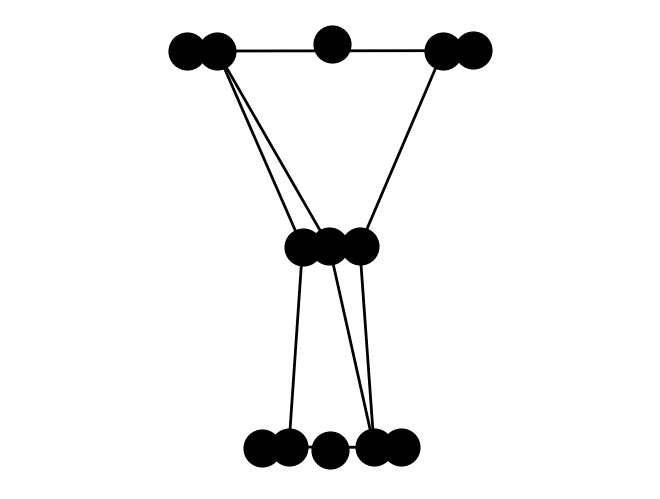

In [9]:
# cross_search_draw()

Gen_xy = {
    0: (38, 260),
    1: (-44, 259),
    2: (-354, 239),
    3: (338, 241),
    4: (-41, -289),
    5: (31, -287),
    6: (-153, -282),
    7: (149, -281),
}
graph_edges = [
    (0, 1),
    (0, 2),
    (0, 3),
    (0, 5),
    (1, 2),
    (1, 3),
    (1, 5),
    (1, 4),
    (4, 7),
    (4, 6),
    (4, 5),
    (5, 6),
    (5, 7),
]

cross_Gen_xy, cross_graph_edges, edge_cross_node_dict = edge_crossing_graph_generate(
    Gen_xy, graph_edges
)
print(cross_graph_edges)

graph_maker(cross_Gen_xy, cross_graph_edges, f"({2},{3})", "MTG", 0)


In [10]:
# graph_color_search_draw()


In [11]:
# MTG_color_search_draw()



In [12]:
# planar_serch_draw()


- 来週までにやること
  - 辺彩色
    - MLG(P)の中で MST(P)を 1 色目
    - MST(P)の辺に交わる辺を 2 色目
    - それ以外を 3 色目
    - 2,2 3,3 色で被りないか
  - 平面性
    - MLG(P)の辺交差グラフは平面的か？実験


In [13]:
# MTG_planar_search_draw()


In [14]:
def make_mst_edges(Gen_xy, graph_edges):
    G = nx.Graph()
    G.add_edges_from(graph_edges)
    for node, coords in Gen_xy.items():
        G.add_node(node, pos=coords)

    mst_edges = list(nx.minimum_spanning_edges(G, algorithm="kruskal", data=False))
    print(mst_edges)
    return mst_edges


def MTG_coloring_test():
    try_num, n, chromatic, k, l, base = input(
        "try_num n chromatic k l base(mst,dg)"
    ).split()
    try_num, n, chromatic, k, l = int(try_num), int(n), int(chromatic), int(k), int(l)
    if try_num == 0:
        try_num = 10000
    for i in progress_bar(range(try_num)):
        Gen_xy = generate_points(n)
        graph_edges = kl_MTG_generate(Gen_xy, k, l)
        if base == "mst":
            base_color_edges = make_mst_edges(Gen_xy, graph_edges)
        elif base == "dg":
            base_color_edges = kDG_generate(Gen_xy, 0)
        coloring = {}
        # 辺彩色のルールを変更
        for edge in graph_edges:
            if (edge[0], edge[1]) in base_color_edges:
                coloring[edge] = 0
            elif (edge[1], edge[0]) in base_color_edges:
                coloring[edge] = 0
            else:
                coloring[edge] = 1

        chromatic_number = max(coloring.values()) + 1
        if chromatic_number == chromatic:
            cross_count_num = cross_count(Gen_xy, graph_edges)
            print(f"{i}回目で見つかりました")
            graph_maker(Gen_xy, graph_edges, f"({k},{l})", "MTG", cross_count_num)
            color_edge_graph_maker(Gen_xy, graph_edges, coloring)
            return
    return f"{try_num}回実行しましたが、見つかりませんでした"


In [15]:
def MTG_generate_test():
    try_num, n, k, l = input("try_num n k l").split()
    try_num, n, k, l = int(try_num), int(n), int(k), int(l)
    if try_num == 0:
        try_num = 10000
    for i in progress_bar(range(try_num)):
        Gen_xy = generate_points(n)
        graph_edges = kl_MTG_generate(Gen_xy, k, l)
        order1_graph_edges = graph_edges - kDG_generate(Gen_xy, 0)
        cross_count_num = cross_count(Gen_xy, graph_edges)
        for j in range(n):
            del_Gen_xy = Gen_xy.copy()
            del del_Gen_xy[n]
            graph_edges = kDG_generate(del_Gen_xy, 0)

        return


In [16]:
# MTG_coloring_test()


- 彩色場合分け
  - MST と(MLG\MST)辺同士の場合分け
  - MLG\MST の交差の場合分け


tkinter を用いて、以下のソフトを作ってください

- 描画する近接グラフ、または(k-l)-tight グラフを選択する(k,l)は入力する
- 右クリックで頂点を追加する
- 辺が張られる状態になった時、辺をキャンバスに描画する
- 頂点は被らずに、general_potison を満たす必要がある
- 左クリックで頂点を消す
- 左クリックで頂点をドラッグする際、その座標にたいしての辺を描画する
- 上部に交差数と頂点数を描画してください


In [17]:
import tkinter as tk
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import math
import itertools
from tkinter import simpledialog, messagebox


class GraphApp:
    def __init__(self, root):
        back_color = "light gray"
        self.root = root
        self.root.title("Graph Drawer")
        self.root.tk.call("tk", "scaling", 1.5)
        self.canvas_width = 800
        self.canvas_height = 600
        self.canvas = tk.Canvas(
            root, width=self.canvas_width, height=self.canvas_height, bg="white"
        )
        self.canvas.pack()
        taskbar_height = 12
        self.root.configure(bg=back_color)
        self.points = []
        self.graph = nx.Graph()
        self.node_radius = 12
        self.grid_lock = tk.BooleanVar(value=False)
        self.show_mst = tk.BooleanVar(value=False)
        self.show_dg = tk.BooleanVar(value=False)
        self.show_edge_crossing = tk.BooleanVar(value=False)
        self.exclude_isolated_nodes = tk.BooleanVar(value=False)
        self.root.bind("<Up>", self.move_node_up)
        self.root.bind("<Down>", self.move_node_down)
        self.root.bind("<Left>", self.move_node_left)
        self.root.bind("<Right>", self.move_node_right)
        self.canvas.bind("<Button-1>", self.add_point)
        self.canvas.bind("<Button-3>", self.remove_point)
        self.canvas.bind("<B1-Motion>", self.move_point)
        self.canvas.bind("<ButtonRelease-1>", self.release_point)
        self.selected_node = None
        self.Gen_xy = {}
        self.k = 2
        self.l = 3
        self.selected_lens_edges = {}
        self.lens_selected_edge_list = []

        # フォントサイズと太さを指定する変数
        font_size = 11
        font_weight = "bold"
        font = tkFont.Font(family="メイリオ", size=font_size, weight=font_weight)

        self.k_label = tk.Label(root, text="k", font=font, bg=back_color)
        self.k_entry = tk.Entry(root, font=font, width=2)

        self.l_label = tk.Label(root, text="l", font=font, bg=back_color)
        self.l_entry = tk.Entry(root, font=font, width=2)
        self.save_label = tk.Label(root, text="", font=font, fg="green")

        self.info_label = tk.Label(
            root,
            text="(2,3)-MTG(P) \n 頂点数:0 辺数:0 交差数:0 厚み:0",
            font=font,
            bg=back_color,
        )
        save_button_font = tkFont.Font(size=8, weight=font_weight)
        self.save_button = tk.Button(
            root,
            text="Save",
            command=self.save_graph,
            font=save_button_font,
            width=8,
            bg="white",
        )
        read_button_font = tkFont.Font(size=8, weight=font_weight)
        clear_button_font = tkFont.Font(size=8, weight=font_weight)
        self.clear_button = tk.Button(
            root,
            text="Clear All",
            command=self.clear_all,
            font=clear_button_font,
            width=8,
            bg="white",
            fg="red",
        )
        self.read_button = tk.Button(
            root,
            text="Read",
            command=self.read_graph,
            font=read_button_font,
            width=8,
            bg="white",
        )

        # オプションボタンを追加
        self.option_button = tk.Button(
            root,
            text="option",
            command=self.show_options,
            font=read_button_font,
            bg="white",
            width=8,
        )

        # 詳細ボタンを追加
        self.detail_button = tk.Button(
            root,
            text="detail",
            command=self.show_detail,
            font=read_button_font,
            bg="white",
            width=8,
        )

        self.show_lens = tk.BooleanVar(value=False)
        self.show_cross_lens = tk.BooleanVar(value=False)
        self.integer_lock = tk.BooleanVar(value=False)
        self.show_not_oo = tk.BooleanVar(value=False)

        # タスクバーのウィジェットを配置
        self.k_label.pack(side=tk.LEFT, padx=5, pady=taskbar_height)
        self.k_entry.pack(side=tk.LEFT, padx=5, pady=taskbar_height)

        self.l_label.pack(side=tk.LEFT, padx=5, pady=taskbar_height)
        self.l_entry.pack(side=tk.LEFT, padx=5, pady=taskbar_height)

        self.clear_button.pack(side=tk.LEFT, padx=5, pady=taskbar_height)
        self.read_button.pack(side=tk.LEFT, padx=5, pady=taskbar_height)
        self.save_button.pack(side=tk.LEFT, padx=5, pady=taskbar_height)
        self.option_button.pack(side=tk.LEFT, padx=5, pady=taskbar_height)
        self.detail_button.pack(side=tk.LEFT, padx=5, pady=taskbar_height)
        self.info_label.pack(side=tk.TOP, fill=tk.X, padx=5, pady=taskbar_height)

        self.draw_grid(self.canvas_width, self.canvas_height, self.canvas)

    def show_options(self):
        options_window = tk.Toplevel(self.root)
        options_window.title("オプション")
        option_button_font = tkFont.Font(size=8, weight="bold")

        edge_crossing_checkbutton = tk.Checkbutton(
            options_window,
            text="辺交差グラフを表示",
            variable=self.show_edge_crossing,
            command=self.show_edge_crossing_window,
            font=option_button_font,
        )
        edge_crossing_checkbutton.pack()

        lens_checkbutton = tk.Checkbutton(
            options_window,
            text="全辺レンズを表示",
            variable=self.show_lens,
            command=self.redraw,
            font=option_button_font,
        )
        lens_checkbutton.pack()

        cross_lens_checkbutton = tk.Checkbutton(
            options_window,
            text="交差辺のみレンズを表示",
            variable=self.show_cross_lens,
            command=self.redraw,
            font=option_button_font,
        )
        cross_lens_checkbutton.pack()

        integer_lock_checkbutton = tk.Checkbutton(
            options_window,
            text="整数で固定する",
            variable=self.integer_lock,
            command=self.redraw,
            font=option_button_font,
        )
        integer_lock_checkbutton.pack()

        mst_checkbutton = tk.Checkbutton(
            options_window,
            text="MSTを赤で彩色",
            variable=self.show_mst,
            command=self.redraw,
            font=option_button_font,
        )
        mst_checkbutton.pack()

        dg_checkbutton = tk.Checkbutton(
            options_window,
            text="DGを青で彩色",
            variable=self.show_dg,
            command=self.redraw,
            font=option_button_font,
        )
        dg_checkbutton.pack()

        not_oo_checkbutton = tk.Checkbutton(
            options_window,
            text="not(O-O)を濃い橙で彩色",
            variable=self.show_not_oo,
            command=self.redraw,
            font=option_button_font,
        )
        not_oo_checkbutton.pack()

        edge_circle_button = tk.Button(
            options_window,
            text="Lens選択",
            command=self.show_lens_select,
            font=option_button_font,
            bg="white",
            width=14,
        )
        edge_circle_button.pack()

    def show_detail(self):
        text = f"頂点数: {len(self.points)}\n辺数: {len(self.graph.edges)}\n交差数: {cross_count(self.Gen_xy, self.graph.edges)} \n厚み: {self.count_thickness(self.Gen_xy, self.graph.edges)} \n辺集合: {self.graph.edges} "
        if self.not_oo:
            text += f"\nnot(O-O): {self.not_oo}"
        if self.oo:
            text += f"\nO-O: {self.oo}"
        detail_window = tk.Toplevel(self.root)
        detail_window.title("詳細")
        detail_button_font = tkFont.Font(size=15, weight="bold")
        detail_label = tk.Label(
            detail_window,
            text=text,
            font=detail_button_font,
        )
        detail_label.pack()

    def select_node(self, event):
        x, y = event.x - self.canvas_width // 2, self.canvas_height // 2 - event.y
        for node, (px, py) in self.points:
            if (px - x) ** 2 + (py - y) ** 2 <= self.node_radius**2:
                self.selected_node = node
                break
        self.redraw()

    def move_node_up(self, event):
        self.move_selected_node(0, 1)

    def move_node_down(self, event):
        self.move_selected_node(0, -1)

    def move_node_left(self, event):
        self.move_selected_node(-1, 0)

    def move_node_right(self, event):
        self.move_selected_node(1, 0)

    def move_selected_node(self, dx, dy):
        if self.selected_node is not None:
            x, y = self.graph.nodes[self.selected_node]["pos"]
            x += dx
            y += dy
            self.graph.nodes[self.selected_node]["pos"] = (x, y)
            self.points = [
                (n, (x, y)) if n == self.selected_node else (n, (px, py))
                for n, (px, py) in self.points
            ]
            self.redraw()

    def draw_grid(self, canvas_width, canvas_height, canvas_name):
        # Draw vertical lines
        for i in range(0, canvas_width, 20):
            canvas_name.create_line(i, 0, i, canvas_height, fill="lightgray")
        # Draw horizontal lines
        for i in range(0, canvas_height, 20):
            canvas_name.create_line(0, i, canvas_width, i, fill="lightgray")
        # Draw central axes
        canvas_name.create_line(
            canvas_width // 2,
            0,
            canvas_width // 2,
            canvas_height,
            fill="gray",
        )
        canvas_name.create_line(
            0,
            canvas_height // 2,
            canvas_width,
            canvas_height // 2,
            fill="gray",
        )

    def add_point(self, event):
        x, y = self.snap_to_grid(
            event.x - self.canvas_width // 2, self.canvas_height // 2 - event.y
        )
        if not self.is_point_overlapping(x, y):
            self.points.append((len(self.points), (x, y)))
            self.graph.add_node(len(self.points) - 1, pos=(x, y))
            self.canvas.create_oval(
                event.x - self.node_radius,
                event.y - self.node_radius,
                event.x + self.node_radius,
                event.y + self.node_radius,
                fill="lightblue",
                outline="black",
                width=2,
            )
            self.canvas.create_text(
                event.x,
                event.y,
                text=f"{len(self.points) - 1}\n({x},{y})",
                font=("Arial", 12, "bold"),
            )
            self.update_edges()
            self.update_info()

    def remove_point(self, event):
        x, y = self.snap_to_grid(
            event.x - self.canvas_width // 2, self.canvas_height // 2 - event.y
        )
        for node, (px, py) in self.points:
            if (px - x) ** 2 + (py - y) ** 2 <= self.node_radius**2:
                self.points = [
                    (n, (px, py)) for n, (px, py) in self.points if n != node
                ]
                self.graph.remove_node(node)
                self.reset_node_numbers()
                self.update_edges()
                self.redraw()
                break

    def reset_node_numbers(self):
        self.graph = nx.relabel_nodes(
            self.graph, {old: new for new, (old, _) in enumerate(self.points)}
        )
        self.points = [(new, pos) for new, (_, pos) in enumerate(self.points)]

    def clear_all(self):
        self.points.clear()
        self.graph.clear()
        self.canvas.delete("all")
        self.redraw()

    def move_point(self, event):
        if self.selected_node is None:
            for node, (px, py) in self.points:
                if (px - (event.x - self.canvas_width // 2)) ** 2 + (
                    py - (self.canvas_height // 2 - event.y)
                ) ** 2 <= self.node_radius**2:
                    self.selected_node = node
                    break
        if self.selected_node is not None:
            x, y = self.snap_to_grid(
                event.x - self.canvas_width // 2, self.canvas_height // 2 - event.y
            )
            self.points = [
                (n, (x, y)) if n == self.selected_node else (n, (px, py))
                for n, (px, py) in self.points
            ]
            self.graph.nodes[self.selected_node]["pos"] = (x, y)
            self.update_edges()
            self.redraw()

    def release_point(self, event):
        self.selected_node = None

    def snap_to_grid(self, x, y):
        if self.integer_lock.get():
            x = round(x / 20) * 20
            y = round(y / 20) * 20

        # 座標をキャンバスの範囲内に制限
        x = max(-self.canvas_width // 2, min(x, self.canvas_width // 2))
        y = max(-self.canvas_height // 2, min(y, self.canvas_height // 2))

        return x, y

    def is_point_overlapping(self, x, y):
        for _, (px, py) in self.points:
            if (px - x) ** 2 + (py - y) ** 2 <= (2 * self.node_radius) ** 2:
                return True
        return False

    def update_edges(self):
        self.graph.clear_edges()
        self.k = int(self.k_entry.get()) if self.k_entry.get() else 2
        self.l = int(self.l_entry.get()) if self.l_entry.get() else 3
        edges = self.kl_generate(self.points, self.k, self.l)
        if edges:
            self.graph.add_edges_from(edges)

    def kl_generate(self, points, k, l):
        self.Gen_xy = {i: pos for i, (i, pos) in enumerate(points)}
        if len(self.Gen_xy) < 2:
            return []
        else:
            if self.k <= 0:
                return []

            elif self.l < 0:
                return []
            elif self.k * len(self.Gen_xy) < self.l:
                return []
        try:
            kl_MTG_generate(self.Gen_xy, self.k, self.l)
            return kl_MTG_generate(self.Gen_xy, self.k, self.l)
        except:
            return []

    def count_thickness(self, Gen_xy, graph_edges):
        cross_Gen_xy, cross_graph_edges = (
            edge_crossing_graph_generate(Gen_xy, graph_edges)[0],
            edge_crossing_graph_generate(Gen_xy, graph_edges)[1],
        )
        return chromatic_number_count(cross_Gen_xy, cross_graph_edges)[0]

    def redraw(self):
        self.canvas.delete("all")
        self.draw_grid(self.canvas_width, self.canvas_height, self.canvas)
        G = nx.Graph()

        pos = nx.get_node_attributes(self.graph, "pos")
        if self.show_mst.get():
            for edge in self.graph.edges:
                x1, y1 = self.Gen_xy[edge[0]]
                x2, y2 = self.Gen_xy[edge[1]]
                weight = np.linalg.norm(np.array([x2 - x1, y2 - y1]))
                G.add_edge(edge[0], edge[1], weight=weight)
            self.mst = nx.minimum_spanning_tree(G, weight="weight")

        if self.show_dg.get():
            self.dg = kDG_generate(self.Gen_xy, 0)

        if self.show_not_oo.get():
            edge_in_out_count = in_out_judge(self.Gen_xy, self.graph.edges)
            not_oo_edges = set()
            oo_edges = set()
            for edge in edge_in_out_count:
                if edge_in_out_count[edge][0] == 0:
                    not_oo_edges.add(edge)
                else:
                    oo_edges.add(edge)
            self.not_oo = not_oo_edges
            self.oo = oo_edges

        # まずエッジを描画
        for edge in self.graph.edges:
            x1, y1 = self.graph.nodes[edge[0]]["pos"]
            x2, y2 = self.graph.nodes[edge[1]]["pos"]
            screen_x1, screen_y1 = (
                x1 + self.canvas_width // 2,
                self.canvas_height // 2 - y1,
            )
            screen_x2, screen_y2 = (
                x2 + self.canvas_width // 2,
                self.canvas_height // 2 - y2,
            )
            if self.show_mst.get():  # MSTを赤色で描写
                if edge in self.mst.edges():
                    self.canvas.create_line(
                        screen_x1, screen_y1, screen_x2, screen_y2, fill="red", width=3
                    )
                else:
                    self.canvas.create_line(
                        screen_x1, screen_y1, screen_x2, screen_y2, fill="gray", width=3
                    )
            elif self.show_dg.get():  # DGを青色で描写
                if edge in self.dg:
                    self.canvas.create_line(
                        screen_x1, screen_y1, screen_x2, screen_y2, fill="blue", width=3
                    )

                else:
                    self.canvas.create_line(
                        screen_x1, screen_y1, screen_x2, screen_y2, fill="gray", width=3
                    )
            elif self.show_not_oo.get():  # not(O-O)を濃い橙で描写
                if edge in self.not_oo:
                    self.canvas.create_line(
                        screen_x1,
                        screen_y1,
                        screen_x2,
                        screen_y2,
                        fill="DarkOrange",
                        width=3,
                    )
                else:
                    self.canvas.create_line(
                        screen_x1, screen_y1, screen_x2, screen_y2, fill="gray", width=3
                    )
            else:
                self.canvas.create_line(
                    screen_x1, screen_y1, screen_x2, screen_y2, fill="gray", width=3
                )

        # 同一円上の点を検出し、円を描画
        for combination in itertools.combinations(self.points, 4):
            (n1, (x1, y1)), (n2, (x2, y2)), (n3, (x3, y3)), (n4, (x4, y4)) = combination
            is_on_circle, cen_x, cen_y, r = is_cocircular(
                x1, y1, x2, y2, x3, y3, x4, y4
            )
            if (is_on_circle) and (cen_x is not None) and (cen_y is not None):
                screen_cen_x, screen_cen_y = (
                    cen_x + self.canvas_width // 2,
                    self.canvas_height // 2 - cen_y,
                )
                self.canvas.create_oval(
                    screen_cen_x - r,
                    screen_cen_y - r,
                    screen_cen_x + r,
                    screen_cen_y + r,
                    outline="red",
                    dash=(4, 2),
                )

        # 次に頂点を描画し、その中に頂点番号を表示
        for node, (x, y) in self.points:
            screen_x, screen_y = x + self.canvas_width // 2, self.canvas_height // 2 - y
            color = "pink" if node == self.selected_node else "lightblue"
            self.canvas.create_oval(
                screen_x - self.node_radius,
                screen_y - self.node_radius,
                screen_x + self.node_radius,
                screen_y + self.node_radius,
                fill=color,
                outline="black",
                width=2,
            )
            self.canvas.create_text(
                screen_x, screen_y, text=f"{node}", font=("Arial", 12, "bold")
            )
            self.canvas.create_text(
                screen_x, screen_y - 20, text=f"({x},{y})", font=("Arial", 12, "bold")
            )

        if self.show_lens.get():
            # 各エッジに対して共通部分の境界線を描画
            for edge in self.graph.edges():
                x1, y1 = pos[edge[0]]
                x2, y2 = pos[edge[1]]
                r = np.linalg.norm(np.array([x2 - x1, y2 - y1]))  # 半径は辺の長さ
                # Shapelyで交差領域を計算
                circle1_shapely = Point(x1, y1).buffer(r)
                circle2_shapely = Point(x2, y2).buffer(r)
                intersection = circle1_shapely.intersection(circle2_shapely)
                if not intersection.is_empty:
                    if isinstance(intersection, Polygon):
                        x, y = intersection.exterior.xy
                        coords = list(zip(x, y))
                        # 中心を(0, 0)にシフト
                        coords = [
                            (cx + self.canvas_width // 2, self.canvas_height // 2 - cy)
                            for cx, cy in coords
                        ]
                        for i in range(len(coords) - 1):
                            self.canvas.create_line(
                                coords[i][0],
                                coords[i][1],
                                coords[i + 1][0],
                                coords[i + 1][1],
                                fill="blue",
                                dash=(4, 2),
                                width=2,
                            )

        if self.lens_selected_edge_list != []:
            # 選択エッジに対して共通部分の境界線を描画
            for edge in self.lens_selected_edge_list:
                x1, y1 = pos[edge[0]]
                x2, y2 = pos[edge[1]]
                r = np.linalg.norm(np.array([x2 - x1, y2 - y1]))  # 半径は辺の長さ
                # Shapelyで交差領域を計算
                circle1_shapely = Point(x1, y1).buffer(r)
                circle2_shapely = Point(x2, y2).buffer(r)
                intersection = circle1_shapely.intersection(circle2_shapely)
                if not intersection.is_empty:
                    if isinstance(intersection, Polygon):
                        x, y = intersection.exterior.xy
                        coords = list(zip(x, y))
                        # 中心を(0, 0)にシフト
                        coords = [
                            (cx + self.canvas_width // 2, self.canvas_height // 2 - cy)
                            for cx, cy in coords
                        ]
                        for i in range(len(coords) - 1):
                            self.canvas.create_line(
                                coords[i][0],
                                coords[i][1],
                                coords[i + 1][0],
                                coords[i + 1][1],
                                fill="orange",
                                dash=(4, 2),
                                width=2,
                            )

        if (self.show_cross_lens.get()) and not (self.show_lens.get()):
            for edge, edge1 in itertools.permutations(self.graph.edges(), 2):
                if cross_judge(
                    self.Gen_xy[edge[0]],
                    self.Gen_xy[edge[1]],
                    self.Gen_xy[edge1[0]],
                    self.Gen_xy[edge1[1]],
                ):
                    x1, y1 = pos[edge[0]]
                    x2, y2 = pos[edge[1]]
                    r = np.linalg.norm(np.array([x2 - x1, y2 - y1]))  # 半径は辺の長さ
                    # Shapelyで交差領域を計算
                    circle1_shapely = Point(x1, y1).buffer(r)
                    circle2_shapely = Point(x2, y2).buffer(r)
                    intersection = circle1_shapely.intersection(circle2_shapely)
                    if not intersection.is_empty:
                        if isinstance(intersection, Polygon):
                            x, y = intersection.exterior.xy
                            coords = list(zip(x, y))
                            # 中心を(0, 0)にシフト
                            coords = [
                                (
                                    cx + self.canvas_width // 2,
                                    self.canvas_height // 2 - cy,
                                )
                                for cx, cy in coords
                            ]
                            for i in range(len(coords) - 1):
                                self.canvas.create_line(
                                    coords[i][0],
                                    coords[i][1],
                                    coords[i + 1][0],
                                    coords[i + 1][1],
                                    fill="green",
                                    dash=(4, 2),
                                    width=3,
                                )

        if self.show_edge_crossing.get():
            self.redraw_edge_crossing_canvas()

        self.update_info()

    def update_info(self):
        cross_count = self.count_crossings()
        vertex_count = len(self.points)
        edge_count = len(self.graph.edges())
        thickness = self.count_thickness(self.Gen_xy, self.graph.edges)
        if self.k <= 0:
            self.info_label.config(text="※ k は0以上の整数で記入してください", fg="red")
        elif self.l < 0:
            self.info_label.config(text="※ l は0以上の整数で記入してください", fg="red")
        elif self.l > 2 * self.k - 1:
            self.info_label.config(
                text=f"※ l は{2 * self.k - 1}以下の整数で記入してください", fg="red"
            )
        else:
            for combination in itertools.combinations(self.Gen_xy.keys(), 3):
                if is_collinear(
                    self.Gen_xy[combination[0]][0],
                    self.Gen_xy[combination[0]][1],
                    self.Gen_xy[combination[1]][0],
                    self.Gen_xy[combination[1]][1],
                    self.Gen_xy[combination[2]][0],
                    self.Gen_xy[combination[2]][1],
                ):
                    self.info_label.config(
                        text=f"※{combination}が同一直線上です。\nグラフを生成できません",
                        fg="red",
                    )
                    return
            for combination in itertools.combinations(self.Gen_xy.keys(), 4):
                if is_cocircular(
                    self.Gen_xy[combination[0]][0],
                    self.Gen_xy[combination[0]][1],
                    self.Gen_xy[combination[1]][0],
                    self.Gen_xy[combination[1]][1],
                    self.Gen_xy[combination[2]][0],
                    self.Gen_xy[combination[2]][1],
                    self.Gen_xy[combination[3]][0],
                    self.Gen_xy[combination[3]][1],
                )[0]:
                    self.info_label.config(
                        text=f"※ {combination}が同一円周上です。\nグラフを生成できません",
                        fg="red",
                    )
                    return
            self.info_label.config(
                text=f"{self.k, self.l}-MTG(P) \n 頂点数:{vertex_count} 辺数:{edge_count} 交差数:{cross_count} 厚み:{thickness}",
                fg="black",
            )
            return

    def count_crossings(self):
        crossings = 0
        edges = list(self.graph.edges())
        for i in range(len(edges)):
            for j in range(i + 1, len(edges)):
                if i != j:
                    if cross_judge(
                        self.Gen_xy[edges[i][0]],
                        self.Gen_xy[edges[i][1]],
                        self.Gen_xy[edges[j][0]],
                        self.Gen_xy[edges[j][1]],
                    ):
                        crossings += 1
        return crossings

    def draw_graph(self):
        pos = nx.get_node_attributes(self.graph, "pos")
        plt.figure()
        nx.draw(
            self.graph,
            pos,
            with_labels=True,
            node_color="lightblue",
            edge_color="black",
            node_size=1000,
            font_size=15,
            font_color="black",
            width=2,
        )
        # plt.show()

    def save_graph(self):
        graph_name = f"({self.k},{self.l})-MTG({len(self.points)})"
        Gen_xy = self.Gen_xy
        edges = list(self.graph.edges())
        vertex_count = len(self.points)
        edge_count = len(self.graph.edges())
        cross_count = self.count_crossings()
        thickness = self.count_thickness(
            Gen_xy, edges
        )  # 厚みの計算が必要な場合は適宜変更
        new_row = [
            graph_name,
            self.k,
            self.l,
            Gen_xy,
            edges,
            vertex_count,
            edge_count,
            cross_count,
            thickness,
        ]

        file_exists = os.path.isfile("./graph.csv")
        new_row_str = [str(item) for item in new_row]
        if file_exists:
            with open("graph.csv", mode="r", newline="") as file:
                reader = csv.reader(file)
                for row in reader:
                    if row == new_row_str:
                        self.info_label.config(
                            text="グラフがファイル内に存在しています", fg="red"
                        )
                        self.root.after(1500, self.update_info)
                        return

        with open("./graph.csv", mode="a", newline="") as file:
            writer = csv.writer(file)
            if not file_exists:
                writer.writerow(
                    [
                        "Graph Name",
                        "k",
                        "l",
                        "Gen_xy",
                        "Edges",
                        "Vertex Count",
                        "Edge Count",
                        "Cross Count",
                        "Thickness",
                    ]
                )
            writer.writerow(new_row)
            # 保存完了メッセージを表示
            self.info_label.config(text="保存しました", fg="green")
            # 一定時間後に元のメッセージに戻す
            self.root.after(1500, self.update_info)
            return

    def update_graph_menu(self):
        if os.path.isfile("graph.csv"):
            with open("graph.csv", mode="r", newline="") as file:
                reader = csv.reader(file)
                next(reader)  # ヘッダーをスキップ
                graph_names = [row[0] for row in reader]
                self.graph_menu["values"] = graph_names

    def read_graph(self):
        if not os.path.isfile("graph.csv"):
            self.info_label.config(text="graph.csvが存在しません", fg="red")
            self.root.after(2000, self.update_info)
            return

        with open("graph.csv", mode="r", newline="") as file:
            reader = csv.reader(file)
            next(reader)  # ヘッダーをスキップ
            rows = list(reader)

        if not rows:
            self.info_label.config(text="graph.csvにデータがありません", fg="red")
            self.root.after(2000, self.update_info)
            return

        selected_row = simpledialog.askinteger(
            "行を選択",
            f"1から{len(rows)}の行番号を入力してください",
            minvalue=1,
            maxvalue=len(rows),
        )
        if selected_row is None:
            return

        selected_row_data = rows[selected_row - 1]
        self.Gen_xy = eval(selected_row_data[3])
        self.k = int(selected_row_data[1])
        self.l = int(selected_row_data[2])
        edges = eval(selected_row_data[4])
        self.points = [(i, pos) for i, pos in self.Gen_xy.items()]
        self.graph.clear()
        self.graph.add_nodes_from(self.Gen_xy.keys())
        for node, pos in self.Gen_xy.items():
            self.graph.nodes[node]["pos"] = pos
        self.graph.add_edges_from(edges)
        self.redraw()
        self.info_label.config(text="グラフを読み込みました", fg="green")
        self.root.after(2000, self.update_info)

    def show_lens_select(self):
        self.lens_selected_edge_list = []
        lens_window = tk.Toplevel(self.root)
        lens_window.title("lens描写オプション")
        lens_label = tk.Label(
            lens_window,
            text="Lensを描写する辺を選択してください",
            font=("Arial", 12, "bold"),
        )
        lens_label.pack()
        for edge in self.graph.edges:
            var = tk.BooleanVar()
            self.selected_lens_edges[edge] = var
            edge_checkbutton = tk.Checkbutton(
                lens_window,
                text=f"{edge}",
                variable=var,
                font=("Arial", 12),
            )
            edge_checkbutton.pack()

        apply_button = tk.Button(
            lens_window, text="適用", command=self.calculate_selected_lens_edges
        )
        delete_button = tk.Button(
            lens_window,
            text="全ての選択を解除",
            command=self.clear_selected_lens_edges,
            fg="red",
        )

        apply_button.pack()
        delete_button.pack()

    def calculate_selected_lens_edges(self):
        for edge, var in self.selected_lens_edges.items():
            if var.get():
                self.lens_selected_edge_list.append(edge)
        self.redraw()

    def clear_selected_lens_edges(self):
        self.lens_selected_edge_list = []
        self.redraw()

    def show_edge_crossing_window(self):
        if self.show_edge_crossing.get():
            # 辺交差グラフの辺と頂点を生成
            cross_Gen_xy, cross_graph_edges, edge_cross_node_dict = (
                edge_crossing_graph_generate(self.Gen_xy, self.graph.edges)
            )

            self.cross_Gen_xy = cross_Gen_xy
            self.cross_graph_edges = cross_graph_edges
            self.edge_cross_node_dict = edge_cross_node_dict

            self.edge_crossing_window = tk.Toplevel(self.root)
            self.edge_crossing_window.title("Edge Crossing Graph")

            # 独立した頂点を除くチェックボタンを追加
            self.header_frame = tk.Frame(self.edge_crossing_window)
            self.header_frame.pack(side=tk.TOP, fill=tk.X)
            # ヘッダーバーを追加
            self.header_label = tk.Label(
                self.header_frame,
                text=f"辺交差グラフ詳細  頂点数: {len(self.cross_Gen_xy)} 辺数: {len(self.cross_graph_edges)} 辺集合: {self.cross_graph_edges}",
                font=("Arial", 12, "bold"),
            )
            self.header_label.pack(side=tk.LEFT, padx=5, pady=5)
            exclude_isolated_nodes_checkbutton = tk.Checkbutton(
                self.header_frame,
                text="次数0の頂点を除く",
                variable=self.exclude_isolated_nodes,
                command=self.redraw_edge_crossing_canvas,
            )
            exclude_isolated_nodes_checkbutton.pack(side=tk.RIGHT, padx=5, pady=5)

            # キャンバスを追加
            canvas_frame = tk.Frame(self.edge_crossing_window)
            canvas_frame.pack(fill=tk.BOTH, expand=True)
            self.edge_crossing_canvas_width = 800
            self.edge_crossing_canvas_height = 600
            self.edge_crossing_canvas = tk.Canvas(
                canvas_frame,
                width=self.edge_crossing_canvas_width,
                height=self.edge_crossing_canvas_height,
                bg="white",
            )  # キャンバスのサイズを大きく変更
            self.edge_crossing_canvas.pack(fill=tk.BOTH, expand=True)

            self.redraw_edge_crossing_canvas()

    def redraw_edge_crossing_canvas(self):
        cross_Gen_xy, cross_graph_edges, edge_cross_node_dict = (
            edge_crossing_graph_generate(self.Gen_xy, self.graph.edges)
        )

        self.cross_Gen_xy = cross_Gen_xy
        self.cross_graph_edges = cross_graph_edges
        self.edge_cross_node_dict = edge_cross_node_dict

        self.edge_crossing_canvas.delete("all")
        self.draw_grid(
            self.edge_crossing_canvas_width,
            self.edge_crossing_canvas_height,
            self.edge_crossing_canvas,
        )
        self.header_label.config(
            text=f"辺交差グラフ詳細  頂点数: {len(self.cross_Gen_xy)} 辺数: {len(self.cross_graph_edges)} 辺集合: {self.cross_graph_edges}"
        )

        # まずエッジを描画
        for edge in self.cross_graph_edges:
            x1, y1 = self.cross_Gen_xy[edge[0]]
            x2, y2 = self.cross_Gen_xy[edge[1]]
            screen_x1, screen_y1 = (
                x1 + self.edge_crossing_canvas_width // 2,
                self.edge_crossing_canvas_height // 2 - y1,
            )
            screen_x2, screen_y2 = (
                x2 + self.edge_crossing_canvas_width // 2,
                self.edge_crossing_canvas_height // 2 - y2,
            )

            self.edge_crossing_canvas.create_line(
                screen_x1, screen_y1, screen_x2, screen_y2, fill="gray", width=3
            )

        if self.exclude_isolated_nodes.get():
            connected_nodes = set()
            for i, j in self.cross_graph_edges:
                connected_nodes.add(i)  # 各辺のノードを追加
                connected_nodes.add(j)

        # 次に頂点を描画し、その中に辺番号(頂点,頂点)を表示

        for node, (x, y) in self.cross_Gen_xy.items():
            if self.exclude_isolated_nodes.get() and node not in connected_nodes:
                continue  # 次数0の頂点を除く
            text = [k for k, v in self.edge_cross_node_dict.items() if v == node][0]

            text = str(text)[1:-1]
            screen_x, screen_y = (
                x + self.edge_crossing_canvas_width // 2,
                self.edge_crossing_canvas_height // 2 - y,
            )
            color = "pink"
            self.edge_crossing_canvas.create_oval(
                screen_x - self.node_radius,
                screen_y - self.node_radius,
                screen_x + self.node_radius,
                screen_y + self.node_radius,
                fill=color,
            )
            self.edge_crossing_canvas.create_text(
                screen_x,
                screen_y + self.node_radius,
                text=f"{text}",
                font=("Arial", 14, "bold"),
            )
            self.edge_crossing_canvas.create_text(
                screen_x,
                screen_y,
                text=f"{node}",
                font=("Arial", 10, "normal"),
            )


if __name__ == "__main__":
    root = tk.Tk()
    app = GraphApp(root)
    root.mainloop()


In [18]:
def in_out_judge(Gen_xy, graph_edges):
    for edge1, edge2 in itertools.combinations(graph_edges, 2):
        print(edge1, edge2)


8
[(16.109826589595375, -286.59537572254334), (30.85911443358252, -285.9743530764807), (31.013208310067967, -285.9678649132603), (-41.0216630131823, -285.0428895920331), (-10.304549675023212, 257.4122562674095), (37.93779414578152, 255.13905682035585), (-43.537352683354435, 255.6319275348203), (-43.98143141023553, 255.6081376030231)]


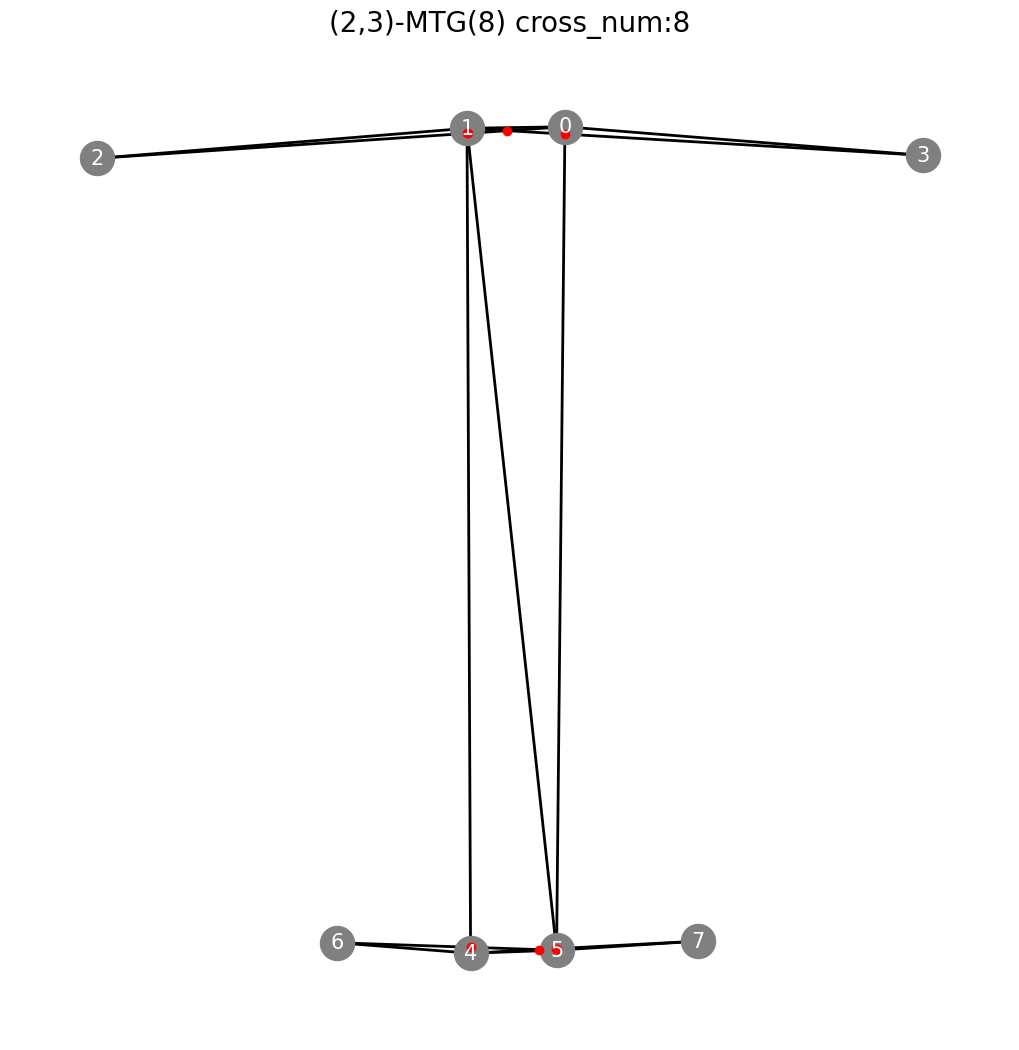

In [19]:
Gen_xy = {
    0: (38, 260),
    1: (-44, 259),
    2: (-354, 239),
    3: (338, 241),
    4: (-41, -289),
    5: (31, -287),
    6: (-153, -282),
    7: (149, -281),
}


graph_edges = kl_MTG_generate(Gen_xy, 2, 3)

graph_resize_maker(
    Gen_xy, graph_edges, "(2,3)", "MTG", cross_count(Gen_xy, graph_edges), (10, 10)
)


In [20]:
def coloring_cross_check(Gen_xy, graph_edges, coloring):
    for edge1, edge2 in itertools.combinations(graph_edges, 2):
        x1, y1 = Gen_xy[edge1[0]]
        x2, y2 = Gen_xy[edge1[1]]
        x3, y3 = Gen_xy[edge2[0]]
        x4, y4 = Gen_xy[edge2[1]]
        if cross_judge((x1, y1), (x2, y2), (x3, y3), (x4, y4)):
            if coloring[edge1] == coloring[edge2]:
                return True
    return False


def coloring_test_01(Gen_xy, graph_edges):
    in_out_judge(Gen_xy, graph_edges)

    # ユークリッド距離を重みとして設定
    G = nx.Graph()
    for edge in graph_edges:
        x1, y1 = Gen_xy[edge[0]]
        x2, y2 = Gen_xy[edge[1]]
        weight = np.linalg.norm(np.array([x2 - x1, y2 - y1]))
        G.add_edge(edge[0], edge[1], weight=weight)

    # 最小全域木（MST）の構築
    mst = nx.minimum_spanning_tree(G, weight="weight")
    # MSTの辺にcolor1を与える
    coloring = {}
    edge_in_out_count = in_out_judge(Gen_xy, graph_edges)

    for edge_in_out_count in edge_in_out_count:
        if edge_in_out_count in mst.edges():
            coloring[edge_in_out_count] = 0
        elif edge_in_out_count[0] >= 1:
            coloring[edge_in_out_count] = 1
        else:
            coloring[edge_in_out_count] = 2

    return coloring


def coloring_test_02(Gen_xy, graph_edges):
    oo_count = 1
    edge_in_out_count = in_out_judge(Gen_xy, graph_edges)
    coloring = {}
    not_oo_edges = set()
    rng_io_edges = set()
    dg_edges = set()
    for edge in edge_in_out_count:
        if edge in kDG_generate(Gen_xy, 0):
            dg_edges.add(edge)
        elif (edge[1], edge[0]) in kDG_generate(Gen_xy, 0):
            dg_edges.add(edge)
        # 0-RNGの作成
        if edge in kRNG_generate(Gen_xy, 0):
            coloring[edge] = 0
            rng_io_edges.add(edge)
        elif (edge[1], edge[0]) in kRNG_generate(Gen_xy, 0):
            coloring[edge] = 0
            rng_io_edges.add(edge)
        # (I-O)交差辺の作成1
        elif edge_in_out_count[edge][0] == 0:
            coloring[edge] = 0
            rng_io_edges.add(edge)
            not_oo_edges.add(edge)

        # (O-O)交差辺の作成
        else:
            coloring[edge] = oo_count
            oo_count += 1

    diff_edges = set()
    for edge in rng_io_edges:
        if edge not in dg_edges:
            if (edge[1], edge[0]) not in dg_edges:
                diff_edges.add(edge)
    return diff_edges, dg_edges, rng_io_edges, coloring, not_oo_edges


In [21]:
def coloring_diff_test():
    try_num, n, k, l = input("try_num n k l").split()
    try_num, n, k, l = int(try_num), int(n), int(k), int(l)
    if try_num == 0:
        try_num = 10000
    for i in progress_bar(range(try_num)):
        Gen_xy = generate_points(n)
        graph_edges = kl_MTG_generate(Gen_xy, k, l)
        coloring = coloring_test_02(Gen_xy, graph_edges)[3]
        dg_edges = coloring_test_02(Gen_xy, graph_edges)[1]
        rng_io_edges = coloring_test_02(Gen_xy, graph_edges)[2]
        diff_edges = coloring_test_02(Gen_xy, graph_edges)[0]
        if diff_edges != set():
            print(f"rng_io{rng_io_edges}")
            print(f"DG{dg_edges}")
            print(f"差分{diff_edges}")
            color_edge_graph_maker(Gen_xy, graph_edges, coloring)
            graph_maker(Gen_xy, dg_edges, 0, "DG", cross_count(Gen_xy, graph_edges))
            print(Gen_xy)
            print(graph_edges)
            break


# coloring_diff_test()


In [22]:
def color_test():
    try_num, n, k, l = input("try_num n k l").split()
    try_num, n, k, l = int(try_num), int(n), int(k), int(l)
    if try_num == 0:
        try_num = 10000
    for i in progress_bar(range(try_num)):
        Gen_xy = generate_points(n)
        graph_edges = kl_MTG_generate(Gen_xy, k, l)
        coloring = coloring_test_02(Gen_xy, graph_edges)[3]
        not_oo_edge = coloring_test_02(Gen_xy, graph_edges)[4]
        if coloring_cross_check(Gen_xy, graph_edges, coloring):
            print("見つかりました。")
            color_edge_graph_maker(Gen_xy, graph_edges, coloring)
            graph_maker(
                Gen_xy, not_oo_edge, 0, "not_oo", cross_count(Gen_xy, graph_edges)
            )
            print(coloring)
            return

    return "見つかりませんでした"


In [23]:
# color_test()


In [24]:
def color_thickness_test():
    try_num, n, k, l = input("try_num n k l").split()
    try_num, n, k, l = int(try_num), int(n), int(k), int(l)
    if try_num == 0:
        try_num = 10000
    for i in progress_bar(range(try_num)):
        Gen_xy = generate_points(n)
        graph_edges = kl_MTG_generate(Gen_xy, k, l)
        coloring = coloring_test_02(Gen_xy, graph_edges)[3]
        not_oo_edge = coloring_test_02(Gen_xy, graph_edges)[4]
        if count_thickness(Gen_xy, not_oo_edge):
            if count_thickness(Gen_xy, not_oo_edge) >= 3:
                print("見つかりました。")
                color_edge_graph_maker(Gen_xy, not_oo_edge, coloring)
                print(coloring)
                return

    return "見つかりませんでした"


In [25]:
# color_thickness_test()


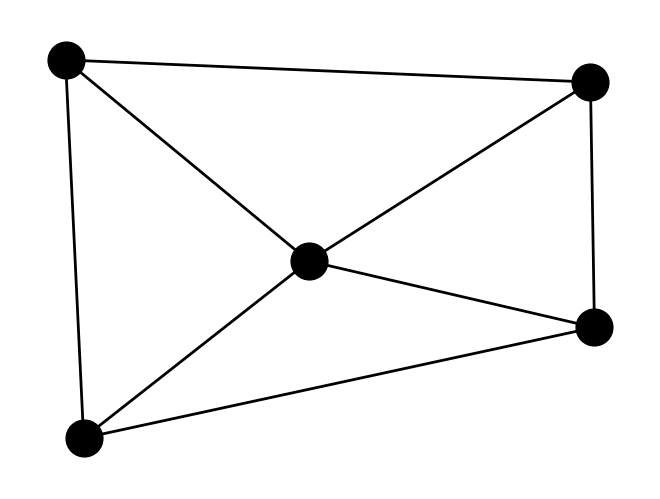

In [26]:
Gen_xy = {0: (-151, -132), 1: (-160, 56), 2: (101, 45), 3: (-39, -44), 4: (103, -77)}

graph_edges = kDG_generate(Gen_xy, 0)
graph_maker(Gen_xy, graph_edges, 0, "DG", 0)


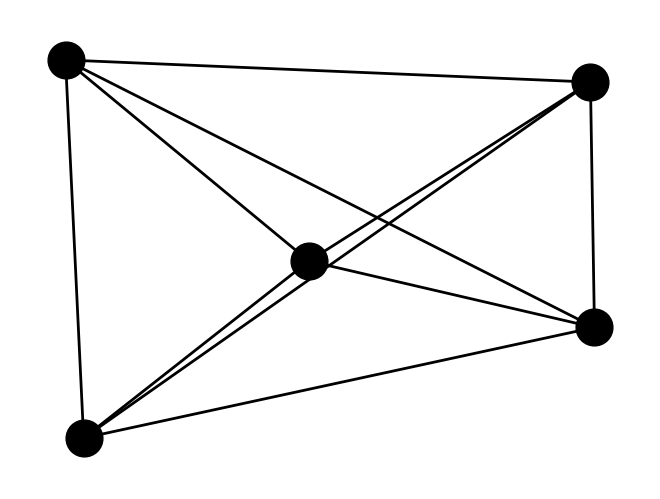

In [27]:
graph_edges = kDG_generate(Gen_xy, 1)
graph_maker(Gen_xy, graph_edges, 1, "DG", 0)


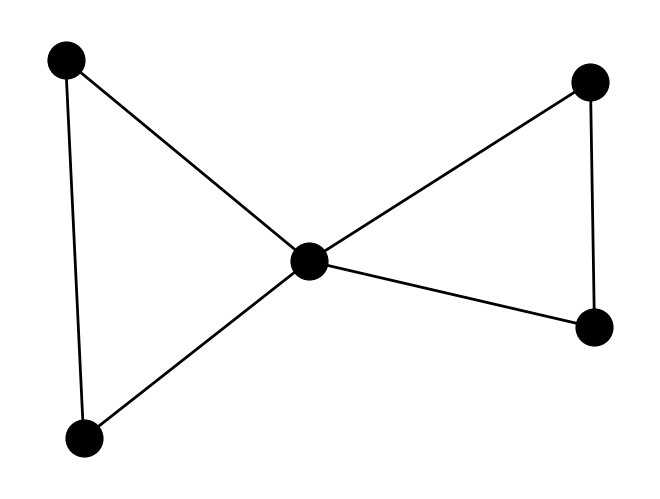

In [28]:
graph_edges = kGG_generate(Gen_xy, 0)
graph_maker(Gen_xy, graph_edges, 0, "GG", 0)


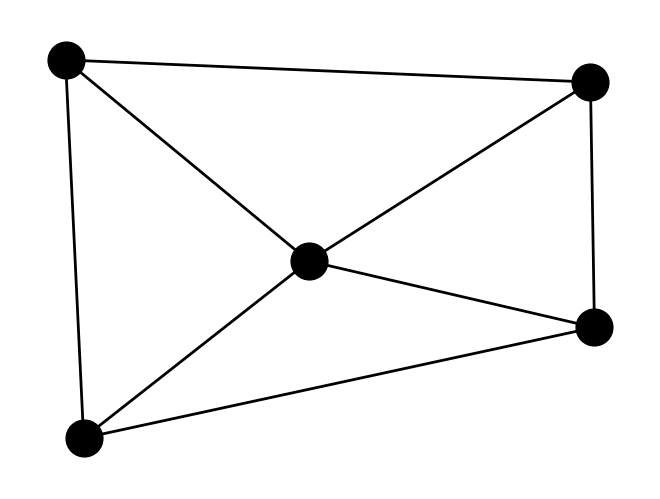

In [29]:
graph_edges = kGG_generate(Gen_xy, 1)
graph_maker(Gen_xy, graph_edges, 1, "GG", 0)


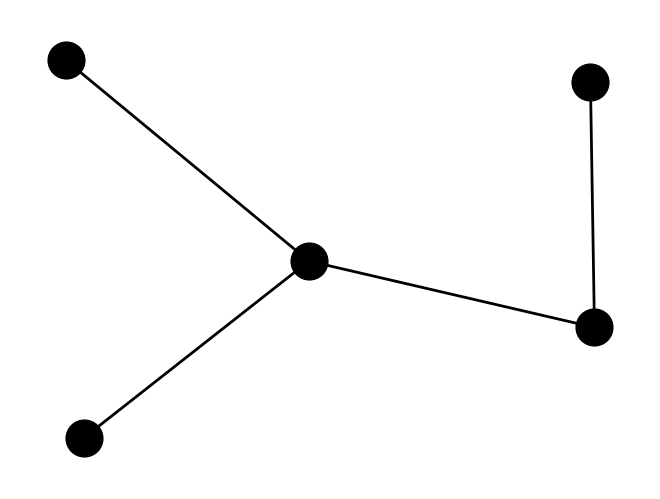

In [30]:
graph_edges = kRNG_generate(Gen_xy, 0)
graph_maker(Gen_xy, graph_edges, 0, "RNG", 0)


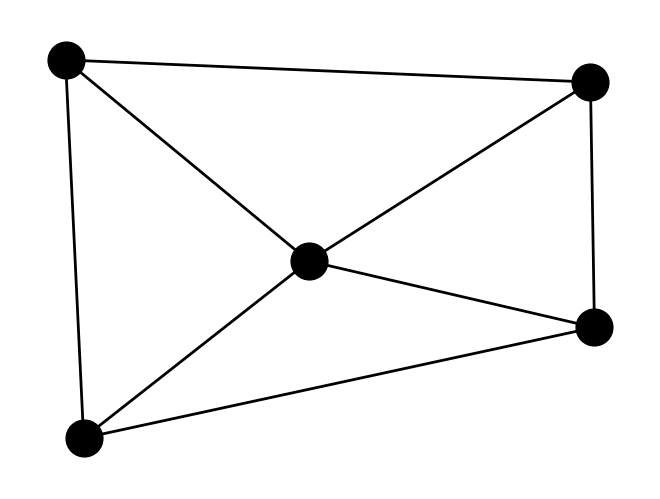

In [31]:
graph_edges = kRNG_generate(Gen_xy, 1)
graph_maker(Gen_xy, graph_edges, 1, "RNG", 0)


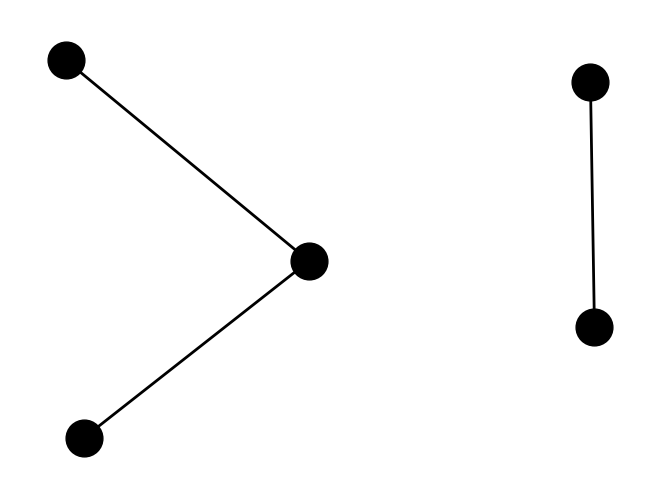

In [32]:
graph_edges = kNNG_generate(Gen_xy, 1)
graph_maker(Gen_xy, graph_edges, 1, "NNG", 0)


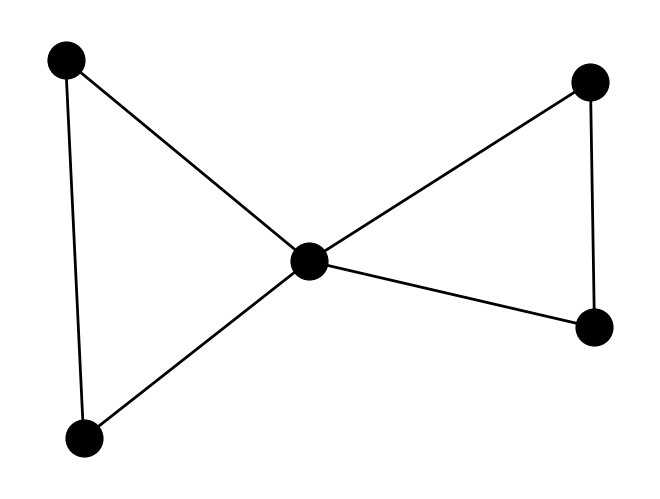

In [ ]:
graph_edges = kNNG_generate(Gen_xy, 2)
graph_maker(Gen_xy, graph_edges, 2, "NNG", 0)


In [34]:
h = 200
down_num_δ = (4 * ε * (2 * h - ε)) ** 0.5
low_start = 2 * h - (4 * h**2 - 1) ** 0.5
up_start = 2 * h + (4 * h**2 - 1) ** 0.5
print(f"ε：0<ε<{low_start}")
print(f"δ：δ<{down_num_δ}")
ε = 0.001
δ = 1.5
a = (0, h)
b = (1, 0)
c = (-1, h - ε)
d = (2 * h - 1, h - ε)
e = (2 - 2 * h, 1)
a_ = (0, -h)
c_ = (-1 - δ, -h + ε)
d_ = (2 * h - 1 - δ, -h + ε)
e_ = (2 - 2 * h, -1)


NameError: name 'ε' is not defined

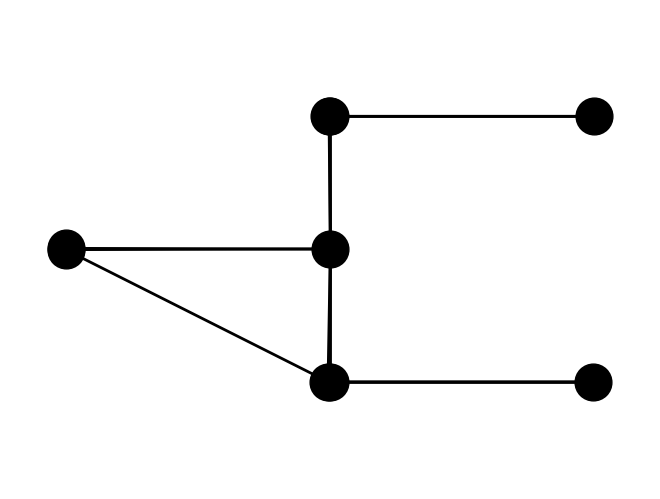

{0: (0, 200), 1: (1, 0), 2: (-1, 199.999), 3: (399, 199.999), 4: (-398, 1), 5: (0, -200), 6: (-2.5, -199.999), 7: (397.5, -199.999), 8: (-398, -1)}
{(0, 1), (2, 1), (7, 5), (1, 8), (2, 0), (5, 1), (3, 0), (7, 6), (5, 6), (0, 5), (8, 6), (4, 8), (1, 6), (3, 2), (4, 1)}


In [62]:
Gen_xy = {0: a, 1: b, 2: c, 3: d, 4: e, 5: a_, 6: c_, 7: d_, 8: e_}
graph_edges = kl_MTG_generate(Gen_xy, 2, 3)
graph_maker(Gen_xy, graph_edges, "(2,3)", "MTG", cross_count(Gen_xy, graph_edges))
print(Gen_xy)
print(graph_edges)


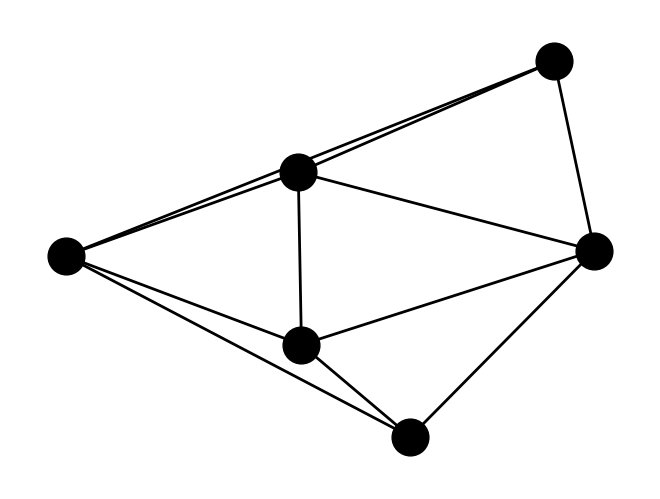

In [66]:
Gen_xy = {
    0: (-209, -23),
    1: (11, 56),
    2: (117, -194),
    3: (253, 161),
    4: (14, -107),
    5: (291, -18),
}
graph_edges = kDG_generate(Gen_xy, 0)
graph_maker(Gen_xy, graph_edges, "(2,3)", "DG", cross_count(Gen_xy, graph_edges))
